In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import albumentations
import albumentations.pytorch
import cv2
import matplotlib.pyplot as plt

In [2]:
CUDA = True
DATA_PATH = 'Anime dataset'
OUT_PATH = 'output'
LOG_FILE = os.path.join(OUT_PATH, 'log.txt')
BATCH_SIZE = 128
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 50
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [3]:
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda')

In [4]:
# image loader
class ADataset(Dataset):
    def __init__(self, transform = None):
        super().__init__()
        
        self.img_dir = "/home/temp_1/kangsanha/AnimeGan/For_pixel2style2pixel/AnimeGan/data/"
        self.filenames = os.listdir(self.img_dir)

        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.filenames[index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR -> RGB
        # albumentations 라이브러리를 사용할 것인데, PIL을 쓰면 변환이 안된다하여 cv2로 변환해준다.
        # img = np.asarray_chkfinite(Image.open(img_path))
        
        if img.dtype == np.uint8:
            img = img / 255.0
        
        if self.transform:
            img_transform = self.transform(image=img)
            img = img_transform['image']
            
       
        return img
        

    def __len__(self):
        
        return len(self.filenames)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN *2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN*4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [9]:
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [10]:
criterion = nn.BCELoss()

optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))

In [11]:
albumentation_compose = albumentations.Compose([
    albumentations.Resize(X_DIM, X_DIM),
    albumentations.pytorch.ToTensorV2(),
])

In [12]:
dataset = ADataset(albumentation_compose)

In [13]:
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=0) 

In [14]:
viz_noise = torch.randn(1, Z_DIM, 1, 1, device=device)

Epoch 0 [0/336] loss_D_real: 1.2246 loss_D_fake: 0.5798 loss_G: 2.6028
Epoch 0 [100/336] loss_D_real: 0.0374 loss_D_fake: 1.4091 loss_G: 16.3162
Epoch 0 [200/336] loss_D_real: 0.1405 loss_D_fake: 0.8961 loss_G: 9.8469
Epoch 0 [300/336] loss_D_real: 0.2339 loss_D_fake: 0.2716 loss_G: 6.0009


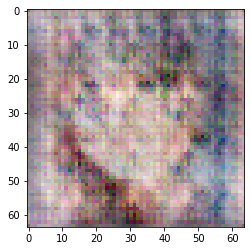

Epoch 1 [0/336] loss_D_real: 0.2503 loss_D_fake: 0.3165 loss_G: 5.6989
Epoch 1 [100/336] loss_D_real: 0.0382 loss_D_fake: 0.9236 loss_G: 11.1113
Epoch 1 [200/336] loss_D_real: 0.1572 loss_D_fake: 0.0135 loss_G: 8.6265
Epoch 1 [300/336] loss_D_real: 0.6695 loss_D_fake: 0.0129 loss_G: 5.7418


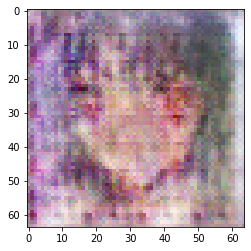

Epoch 2 [0/336] loss_D_real: 0.2662 loss_D_fake: 0.0158 loss_G: 3.9460
Epoch 2 [100/336] loss_D_real: 0.2298 loss_D_fake: 0.4271 loss_G: 6.1649
Epoch 2 [200/336] loss_D_real: 0.2699 loss_D_fake: 0.0624 loss_G: 2.8655
Epoch 2 [300/336] loss_D_real: 1.3017 loss_D_fake: 0.0004 loss_G: 6.2623


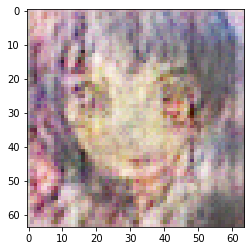

Epoch 3 [0/336] loss_D_real: 0.0331 loss_D_fake: 1.2234 loss_G: 10.5893
Epoch 3 [100/336] loss_D_real: 0.0794 loss_D_fake: 0.1564 loss_G: 5.0064
Epoch 3 [200/336] loss_D_real: 0.9326 loss_D_fake: 0.0029 loss_G: 4.4714
Epoch 3 [300/336] loss_D_real: 0.3790 loss_D_fake: 0.0117 loss_G: 4.8088


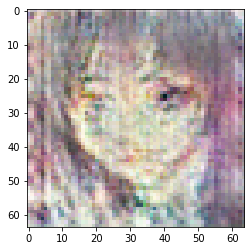

Epoch 4 [0/336] loss_D_real: 0.1635 loss_D_fake: 0.0559 loss_G: 5.1124
Epoch 4 [100/336] loss_D_real: 0.1182 loss_D_fake: 0.0566 loss_G: 6.3447
Epoch 4 [200/336] loss_D_real: 0.1367 loss_D_fake: 0.0777 loss_G: 4.8042
Epoch 4 [300/336] loss_D_real: 0.4093 loss_D_fake: 0.0701 loss_G: 4.1330


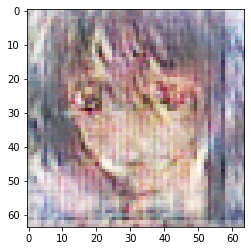

Epoch 5 [0/336] loss_D_real: 0.1636 loss_D_fake: 0.1784 loss_G: 5.8707
Epoch 5 [100/336] loss_D_real: 1.5303 loss_D_fake: 0.0014 loss_G: 2.6565
Epoch 5 [200/336] loss_D_real: 0.0461 loss_D_fake: 0.4197 loss_G: 8.2144
Epoch 5 [300/336] loss_D_real: 0.6476 loss_D_fake: 0.0034 loss_G: 6.5421


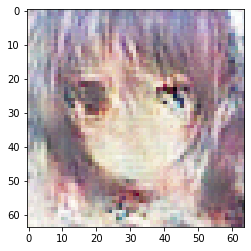

Epoch 6 [0/336] loss_D_real: 0.8906 loss_D_fake: 0.0040 loss_G: 3.4562
Epoch 6 [100/336] loss_D_real: 0.0749 loss_D_fake: 0.5971 loss_G: 9.3220
Epoch 6 [200/336] loss_D_real: 0.2668 loss_D_fake: 0.0390 loss_G: 4.2920
Epoch 6 [300/336] loss_D_real: 0.1629 loss_D_fake: 0.1828 loss_G: 4.4724


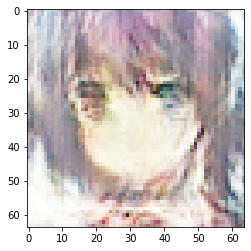

Epoch 7 [0/336] loss_D_real: 0.1096 loss_D_fake: 0.1984 loss_G: 5.3425
Epoch 7 [100/336] loss_D_real: 0.0399 loss_D_fake: 0.4896 loss_G: 7.4346
Epoch 7 [200/336] loss_D_real: 0.3874 loss_D_fake: 0.1516 loss_G: 3.3087
Epoch 7 [300/336] loss_D_real: 0.1062 loss_D_fake: 0.2109 loss_G: 5.0626


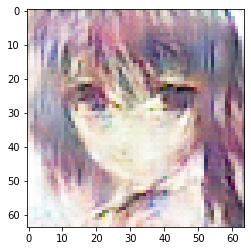

Epoch 8 [0/336] loss_D_real: 0.0672 loss_D_fake: 0.3336 loss_G: 6.0790
Epoch 8 [100/336] loss_D_real: 0.0139 loss_D_fake: 0.6982 loss_G: 7.8741
Epoch 8 [200/336] loss_D_real: 0.2218 loss_D_fake: 0.0931 loss_G: 3.6526
Epoch 8 [300/336] loss_D_real: 0.0555 loss_D_fake: 0.1955 loss_G: 4.6398


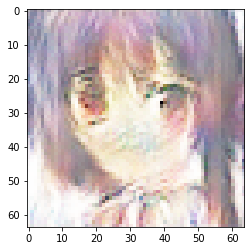

Epoch 9 [0/336] loss_D_real: 0.0726 loss_D_fake: 0.2767 loss_G: 4.9721
Epoch 9 [100/336] loss_D_real: 0.1254 loss_D_fake: 0.0567 loss_G: 5.6779
Epoch 9 [200/336] loss_D_real: 0.0211 loss_D_fake: 1.0352 loss_G: 10.4206
Epoch 9 [300/336] loss_D_real: 0.0662 loss_D_fake: 0.5055 loss_G: 7.1385


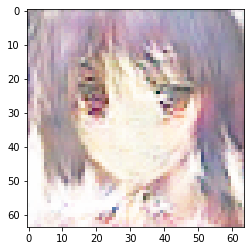

Epoch 10 [0/336] loss_D_real: 0.1051 loss_D_fake: 0.2365 loss_G: 5.1513
Epoch 10 [100/336] loss_D_real: 0.1345 loss_D_fake: 0.1257 loss_G: 3.3697
Epoch 10 [200/336] loss_D_real: 0.0822 loss_D_fake: 0.0651 loss_G: 4.6984
Epoch 10 [300/336] loss_D_real: 0.1742 loss_D_fake: 0.1053 loss_G: 3.8243


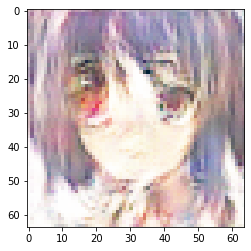

Epoch 11 [0/336] loss_D_real: 0.5523 loss_D_fake: 0.0309 loss_G: 1.4158
Epoch 11 [100/336] loss_D_real: 0.1625 loss_D_fake: 0.0541 loss_G: 4.1519
Epoch 11 [200/336] loss_D_real: 0.0352 loss_D_fake: 0.9801 loss_G: 8.0654
Epoch 11 [300/336] loss_D_real: 0.1333 loss_D_fake: 0.1195 loss_G: 3.9320


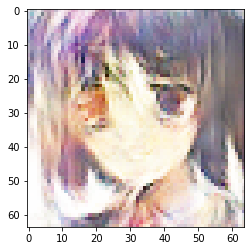

Epoch 12 [0/336] loss_D_real: 0.0826 loss_D_fake: 0.2011 loss_G: 4.8166
Epoch 12 [100/336] loss_D_real: 0.2121 loss_D_fake: 0.1871 loss_G: 3.8274
Epoch 12 [200/336] loss_D_real: 0.8595 loss_D_fake: 0.0072 loss_G: 1.5509
Epoch 12 [300/336] loss_D_real: 0.0370 loss_D_fake: 0.3956 loss_G: 6.0074


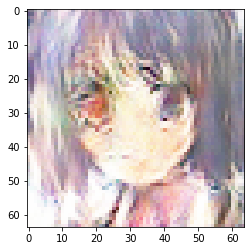

Epoch 13 [0/336] loss_D_real: 0.5134 loss_D_fake: 0.0052 loss_G: 5.8793
Epoch 13 [100/336] loss_D_real: 0.2258 loss_D_fake: 0.0236 loss_G: 4.2953
Epoch 13 [200/336] loss_D_real: 0.3906 loss_D_fake: 0.0571 loss_G: 2.2566
Epoch 13 [300/336] loss_D_real: 0.0708 loss_D_fake: 0.1150 loss_G: 3.7500


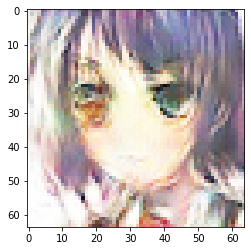

Epoch 14 [0/336] loss_D_real: 0.0332 loss_D_fake: 0.2791 loss_G: 4.8385
Epoch 14 [100/336] loss_D_real: 0.2043 loss_D_fake: 0.1548 loss_G: 3.4099
Epoch 14 [200/336] loss_D_real: 0.1345 loss_D_fake: 0.1075 loss_G: 3.6141
Epoch 14 [300/336] loss_D_real: 0.0135 loss_D_fake: 0.4903 loss_G: 5.3297


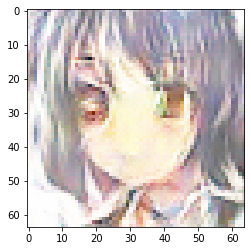

Epoch 15 [0/336] loss_D_real: 0.2730 loss_D_fake: 0.0587 loss_G: 2.3122
Epoch 15 [100/336] loss_D_real: 0.4513 loss_D_fake: 0.0459 loss_G: 3.6420
Epoch 15 [200/336] loss_D_real: 0.0927 loss_D_fake: 0.1233 loss_G: 4.1131
Epoch 15 [300/336] loss_D_real: 0.2355 loss_D_fake: 0.0202 loss_G: 3.9615


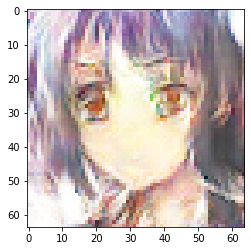

Epoch 16 [0/336] loss_D_real: 0.0095 loss_D_fake: 0.4042 loss_G: 6.5239
Epoch 16 [100/336] loss_D_real: 0.0882 loss_D_fake: 0.1089 loss_G: 4.0963
Epoch 16 [200/336] loss_D_real: 0.1070 loss_D_fake: 0.1156 loss_G: 4.7376
Epoch 16 [300/336] loss_D_real: 0.1555 loss_D_fake: 0.0915 loss_G: 3.0269


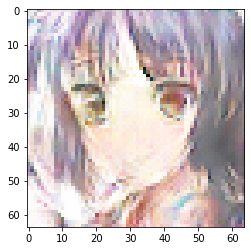

Epoch 17 [0/336] loss_D_real: 0.0864 loss_D_fake: 0.1513 loss_G: 4.1126
Epoch 17 [100/336] loss_D_real: 0.3314 loss_D_fake: 0.0241 loss_G: 3.5685
Epoch 17 [200/336] loss_D_real: 1.7573 loss_D_fake: 0.0005 loss_G: 1.2987
Epoch 17 [300/336] loss_D_real: 0.1144 loss_D_fake: 0.2225 loss_G: 4.3827


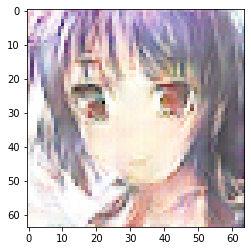

Epoch 18 [0/336] loss_D_real: 0.3946 loss_D_fake: 0.0231 loss_G: 2.6111
Epoch 18 [100/336] loss_D_real: 0.0044 loss_D_fake: 0.7732 loss_G: 7.1273
Epoch 18 [200/336] loss_D_real: 0.1330 loss_D_fake: 0.1032 loss_G: 3.1032
Epoch 18 [300/336] loss_D_real: 0.0322 loss_D_fake: 0.2892 loss_G: 6.3441


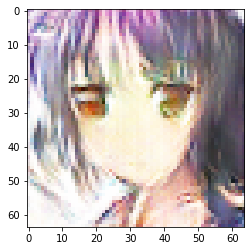

Epoch 19 [0/336] loss_D_real: 0.1252 loss_D_fake: 0.0777 loss_G: 4.7304
Epoch 19 [100/336] loss_D_real: 2.5306 loss_D_fake: 0.0016 loss_G: 2.2343
Epoch 19 [200/336] loss_D_real: 0.0757 loss_D_fake: 0.1018 loss_G: 3.9141
Epoch 19 [300/336] loss_D_real: 0.0441 loss_D_fake: 0.0889 loss_G: 5.1400


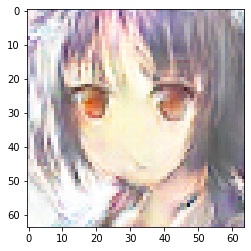

Epoch 20 [0/336] loss_D_real: 0.0337 loss_D_fake: 0.1174 loss_G: 4.2329
Epoch 20 [100/336] loss_D_real: 0.0335 loss_D_fake: 0.2315 loss_G: 5.1939
Epoch 20 [200/336] loss_D_real: 0.5545 loss_D_fake: 0.0606 loss_G: 0.9984
Epoch 20 [300/336] loss_D_real: 0.0570 loss_D_fake: 0.2149 loss_G: 4.7923


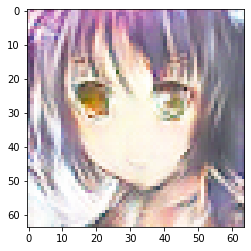

Epoch 21 [0/336] loss_D_real: 0.0106 loss_D_fake: 0.2178 loss_G: 3.6983
Epoch 21 [100/336] loss_D_real: 0.5753 loss_D_fake: 0.0154 loss_G: 2.0563
Epoch 21 [200/336] loss_D_real: 0.0995 loss_D_fake: 0.0789 loss_G: 3.9424
Epoch 21 [300/336] loss_D_real: 0.7714 loss_D_fake: 0.0035 loss_G: 1.4333


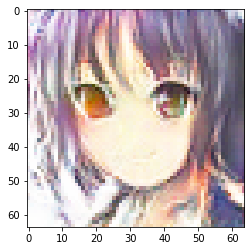

Epoch 22 [0/336] loss_D_real: 0.1740 loss_D_fake: 0.0422 loss_G: 3.2004
Epoch 22 [100/336] loss_D_real: 0.0583 loss_D_fake: 0.2470 loss_G: 5.0551
Epoch 22 [200/336] loss_D_real: 1.0592 loss_D_fake: 0.0024 loss_G: 0.4304
Epoch 22 [300/336] loss_D_real: 0.0980 loss_D_fake: 0.0919 loss_G: 3.5558


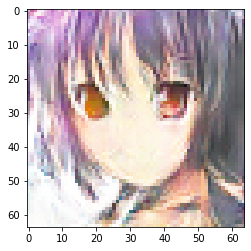

Epoch 23 [0/336] loss_D_real: 0.1112 loss_D_fake: 0.0412 loss_G: 3.8347
Epoch 23 [100/336] loss_D_real: 0.1126 loss_D_fake: 0.1324 loss_G: 3.9199
Epoch 23 [200/336] loss_D_real: 0.1445 loss_D_fake: 0.0572 loss_G: 4.3357
Epoch 23 [300/336] loss_D_real: 0.0967 loss_D_fake: 0.0940 loss_G: 3.5077


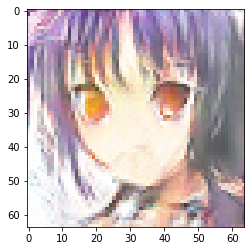

Epoch 24 [0/336] loss_D_real: 0.0118 loss_D_fake: 0.2905 loss_G: 5.3698
Epoch 24 [100/336] loss_D_real: 0.2067 loss_D_fake: 0.0672 loss_G: 3.3967
Epoch 24 [200/336] loss_D_real: 0.1413 loss_D_fake: 0.0243 loss_G: 3.0170
Epoch 24 [300/336] loss_D_real: 1.6120 loss_D_fake: 0.0012 loss_G: 0.1839


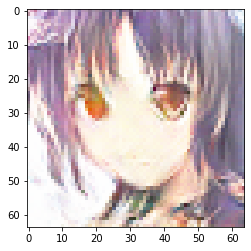

Epoch 25 [0/336] loss_D_real: 0.1385 loss_D_fake: 0.1198 loss_G: 3.1999
Epoch 25 [100/336] loss_D_real: 0.0875 loss_D_fake: 0.0899 loss_G: 4.2337
Epoch 25 [200/336] loss_D_real: 0.0068 loss_D_fake: 1.0829 loss_G: 7.3028
Epoch 25 [300/336] loss_D_real: 0.0106 loss_D_fake: 0.4089 loss_G: 7.2443


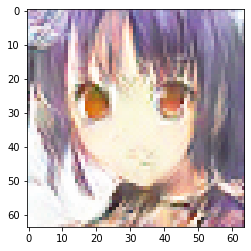

Epoch 26 [0/336] loss_D_real: 0.0669 loss_D_fake: 0.0574 loss_G: 3.7242
Epoch 26 [100/336] loss_D_real: 0.2999 loss_D_fake: 0.0598 loss_G: 4.0680
Epoch 26 [200/336] loss_D_real: 0.1690 loss_D_fake: 0.0271 loss_G: 3.6969
Epoch 26 [300/336] loss_D_real: 0.1305 loss_D_fake: 0.5837 loss_G: 5.0323


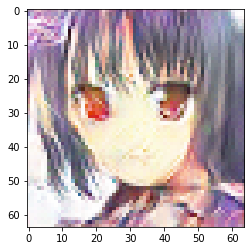

Epoch 27 [0/336] loss_D_real: 0.3525 loss_D_fake: 0.0245 loss_G: 3.6821
Epoch 27 [100/336] loss_D_real: 0.0697 loss_D_fake: 0.0755 loss_G: 3.8515
Epoch 27 [200/336] loss_D_real: 0.0370 loss_D_fake: 0.1140 loss_G: 4.8127
Epoch 27 [300/336] loss_D_real: 0.2065 loss_D_fake: 0.2464 loss_G: 3.4926


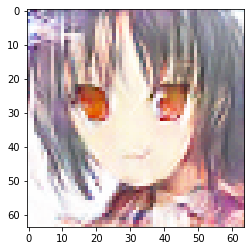

Epoch 28 [0/336] loss_D_real: 0.0732 loss_D_fake: 0.0465 loss_G: 5.0429
Epoch 28 [100/336] loss_D_real: 0.1048 loss_D_fake: 0.0325 loss_G: 3.4951
Epoch 28 [200/336] loss_D_real: 0.1882 loss_D_fake: 0.0106 loss_G: 3.2706
Epoch 28 [300/336] loss_D_real: 0.0039 loss_D_fake: 1.3246 loss_G: 9.1976


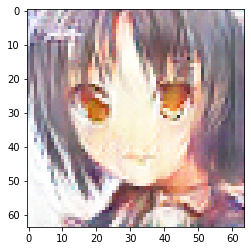

Epoch 29 [0/336] loss_D_real: 0.0262 loss_D_fake: 1.3559 loss_G: 5.6157
Epoch 29 [100/336] loss_D_real: 0.0862 loss_D_fake: 0.0616 loss_G: 3.8667
Epoch 29 [200/336] loss_D_real: 0.0781 loss_D_fake: 0.0486 loss_G: 3.9625
Epoch 29 [300/336] loss_D_real: 0.0024 loss_D_fake: 0.7549 loss_G: 9.1039


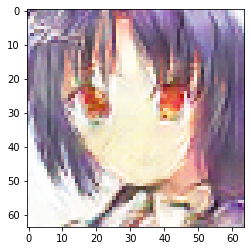

Epoch 30 [0/336] loss_D_real: 0.0420 loss_D_fake: 0.0910 loss_G: 4.7955
Epoch 30 [100/336] loss_D_real: 0.0267 loss_D_fake: 0.0713 loss_G: 3.7456
Epoch 30 [200/336] loss_D_real: 0.0249 loss_D_fake: 1.0820 loss_G: 5.4711
Epoch 30 [300/336] loss_D_real: 0.1419 loss_D_fake: 0.0319 loss_G: 3.9888


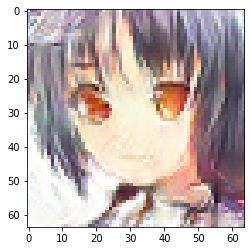

Epoch 31 [0/336] loss_D_real: 0.0325 loss_D_fake: 0.0716 loss_G: 4.9566
Epoch 31 [100/336] loss_D_real: 0.0199 loss_D_fake: 0.1044 loss_G: 4.7781
Epoch 31 [200/336] loss_D_real: 0.0509 loss_D_fake: 0.0832 loss_G: 4.6046
Epoch 31 [300/336] loss_D_real: 0.0575 loss_D_fake: 0.0294 loss_G: 5.0218


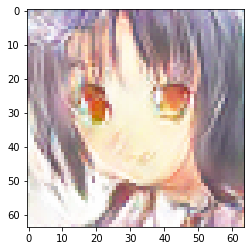

Epoch 32 [0/336] loss_D_real: 0.0871 loss_D_fake: 0.0495 loss_G: 3.8853
Epoch 32 [100/336] loss_D_real: 0.1290 loss_D_fake: 0.0218 loss_G: 3.4484
Epoch 32 [200/336] loss_D_real: 0.0116 loss_D_fake: 2.2297 loss_G: 6.7671
Epoch 32 [300/336] loss_D_real: 0.0031 loss_D_fake: 0.9608 loss_G: 6.8121


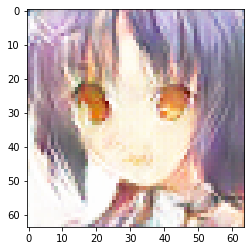

Epoch 33 [0/336] loss_D_real: 0.0036 loss_D_fake: 1.8080 loss_G: 8.9227
Epoch 33 [100/336] loss_D_real: 0.0688 loss_D_fake: 0.0246 loss_G: 4.0102
Epoch 33 [200/336] loss_D_real: 0.0900 loss_D_fake: 0.0481 loss_G: 3.6364
Epoch 33 [300/336] loss_D_real: 0.0237 loss_D_fake: 0.5447 loss_G: 5.1344


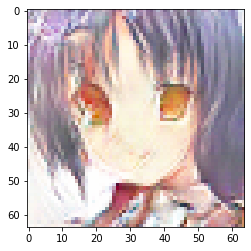

Epoch 34 [0/336] loss_D_real: 0.0573 loss_D_fake: 0.0910 loss_G: 3.5116
Epoch 34 [100/336] loss_D_real: 0.0423 loss_D_fake: 0.0481 loss_G: 4.1960
Epoch 34 [200/336] loss_D_real: 0.5638 loss_D_fake: 0.0949 loss_G: 1.4062
Epoch 34 [300/336] loss_D_real: 0.0172 loss_D_fake: 0.1949 loss_G: 5.9166


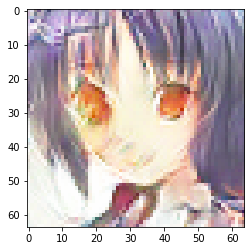

Epoch 35 [0/336] loss_D_real: 0.0206 loss_D_fake: 0.1264 loss_G: 5.2382
Epoch 35 [100/336] loss_D_real: 0.0341 loss_D_fake: 0.0292 loss_G: 4.6320
Epoch 35 [200/336] loss_D_real: 0.0467 loss_D_fake: 0.0371 loss_G: 3.8776
Epoch 35 [300/336] loss_D_real: 0.0689 loss_D_fake: 0.2465 loss_G: 3.7022


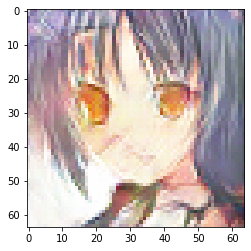

Epoch 36 [0/336] loss_D_real: 0.0211 loss_D_fake: 0.0813 loss_G: 5.6152
Epoch 36 [100/336] loss_D_real: 0.0837 loss_D_fake: 0.0219 loss_G: 3.3464
Epoch 36 [200/336] loss_D_real: 0.0463 loss_D_fake: 0.6066 loss_G: 4.8082
Epoch 36 [300/336] loss_D_real: 0.0796 loss_D_fake: 0.2227 loss_G: 4.5658


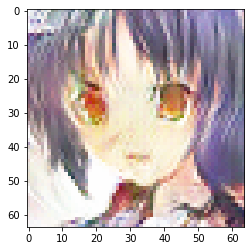

Epoch 37 [0/336] loss_D_real: 0.0162 loss_D_fake: 0.1524 loss_G: 5.3374
Epoch 37 [100/336] loss_D_real: 0.0235 loss_D_fake: 0.0691 loss_G: 4.9055
Epoch 37 [200/336] loss_D_real: 0.1243 loss_D_fake: 0.0057 loss_G: 4.0685
Epoch 37 [300/336] loss_D_real: 0.0399 loss_D_fake: 0.1417 loss_G: 5.1245


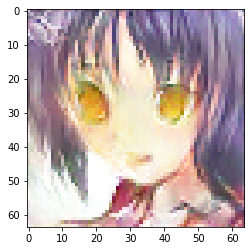

Epoch 38 [0/336] loss_D_real: 0.1674 loss_D_fake: 0.0543 loss_G: 3.4974
Epoch 38 [100/336] loss_D_real: 0.0678 loss_D_fake: 0.0378 loss_G: 4.4913
Epoch 38 [200/336] loss_D_real: 0.0894 loss_D_fake: 0.1806 loss_G: 4.6486
Epoch 38 [300/336] loss_D_real: 0.0230 loss_D_fake: 0.0603 loss_G: 3.9333


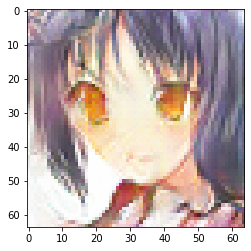

Epoch 39 [0/336] loss_D_real: 0.0371 loss_D_fake: 0.0728 loss_G: 4.2155
Epoch 39 [100/336] loss_D_real: 0.0685 loss_D_fake: 0.0635 loss_G: 4.3251
Epoch 39 [200/336] loss_D_real: 0.0318 loss_D_fake: 0.0367 loss_G: 4.2485
Epoch 39 [300/336] loss_D_real: 0.1110 loss_D_fake: 0.2451 loss_G: 4.1975


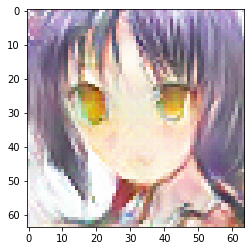

Epoch 40 [0/336] loss_D_real: 0.0850 loss_D_fake: 0.0862 loss_G: 5.0440
Epoch 40 [100/336] loss_D_real: 0.0152 loss_D_fake: 0.0512 loss_G: 3.8853
Epoch 40 [200/336] loss_D_real: 0.0088 loss_D_fake: 0.0943 loss_G: 4.9168
Epoch 40 [300/336] loss_D_real: 0.0947 loss_D_fake: 0.0459 loss_G: 4.1093


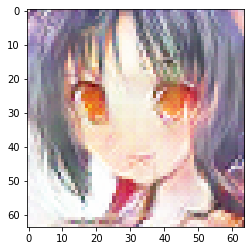

Epoch 41 [0/336] loss_D_real: 0.1568 loss_D_fake: 0.0414 loss_G: 3.9492
Epoch 41 [100/336] loss_D_real: 0.0394 loss_D_fake: 0.0252 loss_G: 4.3123
Epoch 41 [200/336] loss_D_real: 0.0378 loss_D_fake: 0.2862 loss_G: 5.4966
Epoch 41 [300/336] loss_D_real: 0.0628 loss_D_fake: 0.0720 loss_G: 4.2679


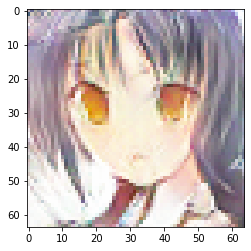

Epoch 42 [0/336] loss_D_real: 0.0108 loss_D_fake: 0.0555 loss_G: 3.7835
Epoch 42 [100/336] loss_D_real: 0.0851 loss_D_fake: 0.0201 loss_G: 3.6540
Epoch 42 [200/336] loss_D_real: 0.0870 loss_D_fake: 0.0119 loss_G: 3.3305
Epoch 42 [300/336] loss_D_real: 0.0263 loss_D_fake: 0.0256 loss_G: 4.3474


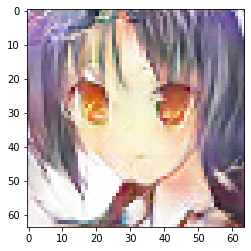

Epoch 43 [0/336] loss_D_real: 0.0357 loss_D_fake: 0.2169 loss_G: 7.0629
Epoch 43 [100/336] loss_D_real: 0.2855 loss_D_fake: 0.1122 loss_G: 2.3144
Epoch 43 [200/336] loss_D_real: 0.0094 loss_D_fake: 0.0676 loss_G: 5.5072
Epoch 43 [300/336] loss_D_real: 0.0051 loss_D_fake: 0.5975 loss_G: 10.0462


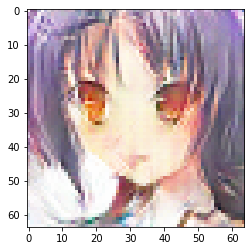

Epoch 44 [0/336] loss_D_real: 0.0044 loss_D_fake: 0.6274 loss_G: 10.7430
Epoch 44 [100/336] loss_D_real: 0.0148 loss_D_fake: 0.0670 loss_G: 5.2716
Epoch 44 [200/336] loss_D_real: 0.0254 loss_D_fake: 0.0322 loss_G: 4.4665
Epoch 44 [300/336] loss_D_real: 0.0182 loss_D_fake: 0.0339 loss_G: 4.5739


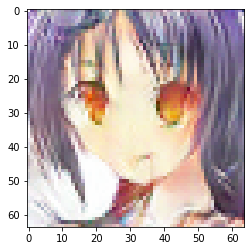

Epoch 45 [0/336] loss_D_real: 0.0177 loss_D_fake: 0.0281 loss_G: 4.4854
Epoch 45 [100/336] loss_D_real: 0.0202 loss_D_fake: 0.0316 loss_G: 4.9102
Epoch 45 [200/336] loss_D_real: 0.2997 loss_D_fake: 0.0071 loss_G: 0.9961
Epoch 45 [300/336] loss_D_real: 0.0552 loss_D_fake: 0.0330 loss_G: 4.7743


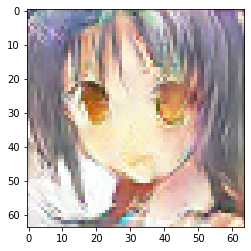

Epoch 46 [0/336] loss_D_real: 0.0225 loss_D_fake: 0.1646 loss_G: 6.0598
Epoch 46 [100/336] loss_D_real: 0.0645 loss_D_fake: 0.0409 loss_G: 4.1663
Epoch 46 [200/336] loss_D_real: 0.0627 loss_D_fake: 0.0177 loss_G: 3.9347
Epoch 46 [300/336] loss_D_real: 1.0895 loss_D_fake: 0.0507 loss_G: 0.6105


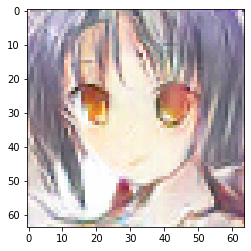

Epoch 47 [0/336] loss_D_real: 0.2424 loss_D_fake: 0.0384 loss_G: 4.1662
Epoch 47 [100/336] loss_D_real: 0.0362 loss_D_fake: 0.0372 loss_G: 4.7633
Epoch 47 [200/336] loss_D_real: 0.0296 loss_D_fake: 0.0357 loss_G: 4.5114
Epoch 47 [300/336] loss_D_real: 0.0004 loss_D_fake: 1.2139 loss_G: 11.5687


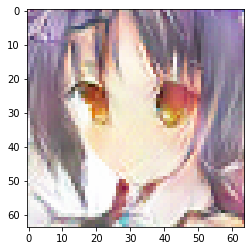

Epoch 48 [0/336] loss_D_real: 0.0579 loss_D_fake: 0.0534 loss_G: 3.8521
Epoch 48 [100/336] loss_D_real: 0.0283 loss_D_fake: 0.0311 loss_G: 4.7716
Epoch 48 [200/336] loss_D_real: 0.0572 loss_D_fake: 0.0179 loss_G: 3.1924
Epoch 48 [300/336] loss_D_real: 0.4065 loss_D_fake: 0.1162 loss_G: 2.7854


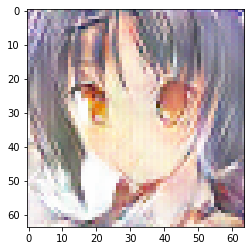

Epoch 49 [0/336] loss_D_real: 0.0062 loss_D_fake: 0.5166 loss_G: 7.6265
Epoch 49 [100/336] loss_D_real: 0.0296 loss_D_fake: 0.0321 loss_G: 4.6068
Epoch 49 [200/336] loss_D_real: 0.0147 loss_D_fake: 0.0719 loss_G: 5.5760
Epoch 49 [300/336] loss_D_real: 0.0512 loss_D_fake: 0.0096 loss_G: 4.5952


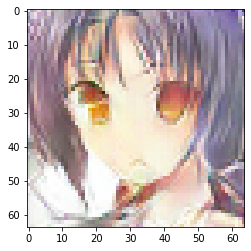

In [15]:
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader):
        x_real = data.to(device).float()
        real_label = torch.full((x_real.size(0),), REAL_LABEL, device=device, dtype=torch.float)
        fake_label = torch.full((x_real.size(0),), FAKE_LABEL, device=device, dtype=torch.float)

        netD.zero_grad()
        y_real = netD(x_real)
        loss_D_real = criterion(y_real, real_label)
        loss_D_real.backward()
        
        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = netG(z_noise)
        y_fake = netD(x_fake.detach())
        loss_D_fake = criterion(y_fake, fake_label)
        loss_D_fake.backward()
        optimizerD.step()
        
        netG.zero_grad()
        y_fake_r = netD(x_fake)
        loss_G = criterion(y_fake_r, real_label)
        loss_G.backward()
        optimizerG.step()
        
        if i % 100 == 0:
            print('Epoch {} [{}/{}] loss_D_real: {:.4f} loss_D_fake: {:.4f} loss_G: {:.4f}'.format(
            epoch, i, len(dataloader), loss_D_real.mean().item(), loss_D_fake.mean().item(),
            loss_G.mean().item()))
             
    viz_sample = netG(viz_noise).cpu()
    plt.imshow(vutils.make_grid(viz_sample, normalize=True).permute(1,2,0))
    plt.show()